بسم الله 

** Importing liberies and frameworks **

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Load videos and Preprocessing : ** defines a function load_video that takes a path to a video file as input and returns a preprocessed version of the video frames as a list of TensorFlow tensors lets eplain this with a simple graphe *

Test the function (LOad_video)

In [2]:
def load_video(path:str) -> List[float]:
    cap=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame=tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean=tf.math.reduce_mean(frames)
    std=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean),tf.float32)/std

In [3]:
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
value=load_video(path)
value

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

**Extracts information from files, and compiles a vocabulary list**

In [4]:
#ADDITIONAL FUNCTION I MADE TO GET vocab WHICH IS A PARAMETER FOR THE CHAR_TO_NUM FUNCTION
def get_vocab():
    vocab=[]
    directory="/kaggle/input/lipreading/data/alignments/s1"
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                line=line.split()
                vocab.append(line[2])
    return vocab       

In [5]:
vocab=np.unique(get_vocab())

In [6]:
print(vocab)

['a' 'again' 'at' 'b' 'bin' 'blue' 'by' 'c' 'd' 'e' 'eight' 'f' 'five'
 'four' 'g' 'green' 'h' 'i' 'in' 'j' 'k' 'l' 'lay' 'm' 'n' 'nine' 'now'
 'o' 'one' 'p' 'place' 'please' 'q' 'r' 'red' 's' 'set' 'seven' 'sil'
 'six' 'soon' 'sp' 't' 'three' 'two' 'u' 'v' 'white' 'with' 'x' 'y' 'z'
 'zero']


> Create a Mapping layers for preprocessing using tensorflow Stringlookup :tf.keras.layers.StringLookup

In [7]:
char_to_num= tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char=tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="",invert=True)

> char_to_num StringLookup Layer:
> 
> tf.keras.layers.StringLookup is used to create a layer that maps characters to numerical indices.
> The vocabulary parameter is set to your vocab, which is the list of characters obtained from your get_vocab function.
> oov_token stands for "out-of-vocabulary" token and is set to an empty string (""). This token is used for unseen characters during inference.
> num_to_char StringLookup Layer:
> 
> Another StringLookup layer is created to map numerical indices back to characters.
> The vocabulary parameter is set to the vocabulary obtained from the char_to_num layer using char_to_num.get_vocabulary().
> oov_token is also set to an empty string (""), and invert is set to True, indicating that this layer should perform an inverse mapping.

> *After convert the alignments to a num (Conversion to Numerical Indices) ---> reshape the tensor to one dim tensor*

In [8]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines=f.readlines()
        
            
        
    tokens=[]
    for line in lines:
        line=line.split()
        if line[2]!= 'sil':
            tokens= [*tokens,' ',line[2]]
        
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,input_encoding='UTF-8'),(-1)))[1:]

In [9]:
path="/kaggle/input/lipreading/data/alignments/s1/bbaf2n.align"
load_alignments(path)


<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 4, 18, 25,  0,  4, 22, 46, 10,  0,  1, 43,  0, 12,  0, 43,  0, 28,
        0, 25, 28,  0])>

In [10]:
def load_data(path:str):
    path=bytes.decode(path.numpy())
    file_name=path.split('/')[-1].split('.')[0]
    video_path=os.path.join('/kaggle/input/lipreading/data','s1',f'{file_name}.mpg')
    alignment_path=os.path.join('/kaggle/input/lipreading/data','alignments','s1',f'{file_name}.align')
    frames=load_video(video_path)
    alignments=load_alignments(alignment_path)
    
    return frames,alignments

In [11]:
#TESTING THE OUTPUT FOR A SAMPLE FILE
path="/kaggle/input/lipreading/data/s1/bbaf2n.mpg"
frames, alignments=load_data(tf.convert_to_tensor(path))
print("frames:",frames)
print("alignments:",alignments)

frames: tf.Tensor(
[[[[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4991663 ]
   [1.4991663 ]
   [1.4616871 ]
   ...
   [0.41227072]
   [0.41227072]
   [0.41227072]]

  [[1.4616871 ]
   [1.4616871 ]
   [1.4991663 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  ...

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.11243746]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.11243746]
   [0.07495831]
   [0.07495831]]

  [[1.0494163 ]
   [1.0494163 ]
   [1.0119373 ]
   ...
   [0.07495831]
   [0.07495831]
   [0.03747915]]]


 [[[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.3373124 ]
   [0.3373124 ]
   [0.3373124 ]]

  [[1.4242079 ]
   [1.4242079 ]
   [1.4242079 ]
   ...
   [0.29983324]
   [0.29983324]
   [0.29983324]]

  ...

  [[1.0494163 ]
   [

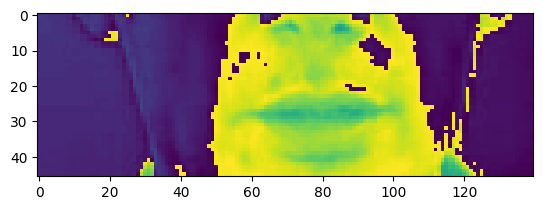

In [12]:
plt.imshow(frames[15])

**
Sets up a TensorFlow data pipeline for loading lipreading data from video file**

In [13]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [14]:
data = tf.data.Dataset.list_files('/kaggle/input/lipreading/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # ADDED DOR SPLIT
train = data.take(450)
test = data.skip(450)

In [15]:
frames, alighnments = data.as_numpy_iterator().next()

In [16]:
sample = data.as_numpy_iterator()

In [17]:
val = sample.next();val[0]

array([[[[[1.3224449 ],
          [1.2509614 ],
          [1.3581866 ],
          ...,
          [0.35741755],
          [0.32167578],
          [0.32167578]],

         [[1.2509614 ],
          [1.2509614 ],
          [1.3581866 ],
          ...,
          [0.35741755],
          [0.32167578],
          [0.32167578]],

         [[1.4296702 ],
          [1.4296702 ],
          [1.4296702 ],
          ...,
          [0.3931593 ],
          [0.35741755],
          [0.35741755]],

         ...,

         [[1.0007691 ],
          [1.0007691 ],
          [0.9292856 ],
          ...,
          [0.10722526],
          [0.07148351],
          [0.07148351]],

         [[1.0007691 ],
          [1.0007691 ],
          [0.9292856 ],
          ...,
          [0.10722526],
          [0.10722526],
          [0.10722526]],

         [[1.0007691 ],
          [1.0007691 ],
          [0.9292856 ],
          ...,
          [0.10722526],
          [0.10722526],
          [0.07148351]]],


        [[[1.4654

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D,Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [19]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [20]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [22]:
yhat = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [23]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [24]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [25]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [27]:
history = model.fit(train, validation_data=test, epochs=40, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/40
 66/450 [===>..........................] - ETA: 5:51 - loss: 108.7294

[mpeg1video @ 0x780fa008ecc0] ac-tex damaged at 22 17
[mpeg1video @ 0x780fa008ecc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 83.1628

[mpeg1video @ 0x781184038140] ac-tex damaged at 22 17
[mpeg1video @ 0x781184038140] Warning MVs not available
[mpeg1video @ 0x781178001780] ac-tex damaged at 22 17
[mpeg1video @ 0x781178001780] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: placehiteatjsixno
Prediction: leeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layblueatktoplease
Prediction: leeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 894s 2s/step - loss: 83.1628 - val_loss: 68.3314 - lr: 1.0000e-04
Epoch 2/40
361/450 [=======================>......] - ETA: 1:22 - loss: 69.9759

[mpeg1video @ 0x781178097340] ac-tex damaged at 22 17
[mpeg1video @ 0x781178097340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 69.6388

[mpeg1video @ 0x780fac08f680] ac-tex damaged at 22 17
[mpeg1video @ 0x780fac08f680] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: setblueattsixno
Prediction: laeeeeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreeninfonesoon
Prediction: laeeieo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 662s 1s/step - loss: 69.6388 - val_loss: 63.6033 - lr: 1.0000e-04
Epoch 3/40
211/450 [=============>................] - ETA: 3:42 - loss: 66.2058

[mpeg1video @ 0x78101c0b5d40] ac-tex damaged at 22 17
[mpeg1video @ 0x78101c0b5d40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 65.3554

[mpeg1video @ 0x56a59c16cb40] ac-tex damaged at 22 17
[mpeg1video @ 0x56a59c16cb40] Warning MVs not available


1/1 [==============================] - 0s 194ms/step
Original: bingreenithheightno
Prediction: laeeteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredbytthreeagain
Prediction: laeeteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 660s 1s/step - loss: 65.3554 - val_loss: 60.4956 - lr: 1.0000e-04
Epoch 4/40
316/450 [====================>.........] - ETA: 2:04 - loss: 63.1982

[mpeg1video @ 0x78100000d200] ac-tex damaged at 22 17
[mpeg1video @ 0x78100000d200] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 62.8885

[mpeg1video @ 0x78117c0d5040] ac-tex damaged at 22 17
[mpeg1video @ 0x78117c0d5040] Warning MVs not available


1/1 [==============================] - 0s 197ms/step
Original: placeredbyqoneagain
Prediction: laeteo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placebluebyvsixno
Prediction: laeee
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 658s 1s/step - loss: 62.8885 - val_loss: 59.4382 - lr: 1.0000e-04
Epoch 5/40
173/450 [==========>...................] - ETA: 4:15 - loss: 61.2061

[mpeg1video @ 0x780fc403ec40] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc403ec40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 60.7581

[mpeg1video @ 0x7810a41f04c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7810a41f04c0] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: setgreenithjsevenagain
Prediction: laetea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueatgeightno
Prediction: laetea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 659s 1s/step - loss: 60.7581 - val_loss: 56.7892 - lr: 1.0000e-04
Epoch 6/40
358/450 [======================>.......] - ETA: 1:25 - loss: 59.4361

[mpeg1video @ 0x780c18076800] ac-tex damaged at 22 17
[mpeg1video @ 0x780c18076800] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 59.4356

[mpeg1video @ 0x780fc809d200] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc809d200] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: placegreenbyysevenagain
Prediction: laretean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredithvtoplease
Prediction: lareteea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 655s 1s/step - loss: 59.4356 - val_loss: 55.4198 - lr: 1.0000e-04
Epoch 7/40
287/450 [==================>...........] - ETA: 2:30 - loss: 56.0811

[mpeg1video @ 0x78118c0f0100] ac-tex damaged at 22 17
[mpeg1video @ 0x78118c0f0100] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 55.5380

[mpeg1video @ 0x780fb805c5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x780fb805c5c0] Warning MVs not available


1/1 [==============================] - 0s 190ms/step
Original: sethitebyvfiveagain
Prediction: lareiteeo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredatssevensoon
Prediction: laeteon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 656s 1s/step - loss: 55.5380 - val_loss: 51.2075 - lr: 1.0000e-04
Epoch 8/40
312/450 [===================>..........] - ETA: 2:07 - loss: 53.7836

[mpeg1video @ 0x7811681e3680] ac-tex damaged at 22 17
[mpeg1video @ 0x7811681e3680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 53.6806

[mpeg1video @ 0x780fa00abc00] ac-tex damaged at 22 17
[mpeg1video @ 0x780fa00abc00] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: placegreenbyknineagain
Prediction: lareteean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredbyqzeroplease
Prediction: lareieea
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 656s 1s/step - loss: 53.6806 - val_loss: 50.3007 - lr: 1.0000e-04
Epoch 9/40
450/450 [==============================] - ETA: 0s - loss: 52.2673

[mpeg1video @ 0x7811801add00] ac-tex damaged at 22 17
[mpeg1video @ 0x7811801add00] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: bingreenithbfourno
Prediction: lareieean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehiteinpeightplease
Prediction: lareieeae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 656s 1s/step - loss: 52.2673 - val_loss: 48.0495 - lr: 1.0000e-04
Epoch 10/40
 19/450 [>.............................] - ETA: 6:30 - loss: 50.8292

[mpeg1video @ 0x780fc8081980] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc8081980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 49.8700

[mpeg1video @ 0x7810a4007600] ac-tex damaged at 22 17
[mpeg1video @ 0x7810a4007600] Warning MVs not available


1/1 [==============================] - 0s 194ms/step
Original: layblueithrthreesoon
Prediction: lareiean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehiteithyfiveagain
Prediction: lareieean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 652s 1s/step - loss: 49.8700 - val_loss: 45.3638 - lr: 1.0000e-04
Epoch 11/40
 15/450 [>.............................] - ETA: 6:37 - loss: 47.5863

[mpeg1video @ 0x780fb40e5f40] ac-tex damaged at 22 17
[mpeg1video @ 0x780fb40e5f40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 47.7049

[mpeg1video @ 0x7810141deb40] ac-tex damaged at 22 17
[mpeg1video @ 0x7810141deb40] Warning MVs not available


1/1 [==============================] - 0s 211ms/step
Original: setgreenithdzerono
Prediction: lareitno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredinpthreeagain
Prediction: lareieean
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 655s 1s/step - loss: 47.7049 - val_loss: 42.6622 - lr: 1.0000e-04
Epoch 12/40
335/450 [=====================>........] - ETA: 1:45 - loss: 45.5885

[mpeg1video @ 0x780c100bce00] ac-tex damaged at 22 17
[mpeg1video @ 0x780c100bce00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 45.5179

[mpeg1video @ 0x780fc41f8640] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc41f8640] Warning MVs not available


1/1 [==============================] - 0s 194ms/step
Original: setgreeninithreesoon
Prediction: lareieo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredbygfourplease
Prediction: larebease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 650s 1s/step - loss: 45.5179 - val_loss: 42.3781 - lr: 1.0000e-04
Epoch 13/40
430/450 [===========================>..] - ETA: 18s - loss: 43.2630

[mpeg1video @ 0x78117c0739c0] ac-tex damaged at 22 17
[mpeg1video @ 0x78117c0739c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 43.2599

[mpeg1video @ 0x780c1803c240] ac-tex damaged at 22 17
[mpeg1video @ 0x780c1803c240] Warning MVs not available


1/1 [==============================] - 0s 192ms/step
Original: layredinyonesoon
Prediction: sitretoo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueinrsixno
Prediction: plablueiieo
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 653s 1s/step - loss: 43.2599 - val_loss: 38.5853 - lr: 1.0000e-04
Epoch 14/40
174/450 [==========>...................] - ETA: 4:11 - loss: 41.5290

[mpeg1video @ 0x7810200060c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7810200060c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 41.1834

[mpeg1video @ 0x56a59c105880] ac-tex damaged at 22 17
[mpeg1video @ 0x56a59c105880] Warning MVs not available


1/1 [==============================] - 0s 189ms/step
Original: setredatbthreeagain
Prediction: sitrebieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setbluebybzeroplease
Prediction: plabluebyoplae
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 650s 1s/step - loss: 41.1834 - val_loss: 36.2556 - lr: 1.0000e-04
Epoch 15/40
294/450 [==================>...........] - ETA: 2:23 - loss: 38.6857

[mpeg1video @ 0x780fc006d8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc006d8c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 38.4745

[mpeg1video @ 0x78117006ea00] ac-tex damaged at 22 17
[mpeg1video @ 0x78117006ea00] Warning MVs not available


1/1 [==============================] - 0s 196ms/step
Original: binredithnzerono
Prediction: placegreitono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredatsppsevenagain
Prediction: placegrebyeieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 652s 1s/step - loss: 38.4745 - val_loss: 33.2018 - lr: 1.0000e-04
Epoch 16/40
 81/450 [====>.........................] - ETA: 5:36 - loss: 37.3549

[mpeg1video @ 0x780b793c5600] ac-tex damaged at 22 17
[mpeg1video @ 0x780b793c5600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 36.3216

[mpeg1video @ 0x78101809fc00] ac-tex damaged at 22 17
[mpeg1video @ 0x78101809fc00] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: laygreenatstono
Prediction: setreitono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binhiteinsninesoon
Prediction: sethreitoeon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 651s 1s/step - loss: 36.3216 - val_loss: 32.7547 - lr: 1.0000e-04
Epoch 17/40
411/450 [==========================>...] - ETA: 35s - loss: 34.2564

[mpeg1video @ 0x780c188268c0] ac-tex damaged at 22 17
[mpeg1video @ 0x780c188268c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 34.2696

[mpeg1video @ 0x780fc804f100] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc804f100] Warning MVs not available


1/1 [==============================] - 0s 170ms/step
Original: layredspithlfivesoon
Prediction: satreiteieson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layhiteithssevenagain
Prediction: seyhrteiteieain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 646s 1s/step - loss: 34.2696 - val_loss: 28.4319 - lr: 1.0000e-04
Epoch 18/40
360/450 [=======================>......] - ETA: 1:22 - loss: 32.2834

[mpeg1video @ 0x78117c0a9740] ac-tex damaged at 22 17
[mpeg1video @ 0x78117c0a9740] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 32.4257

[mpeg1video @ 0x780b8ac971c0] ac-tex damaged at 22 17
[mpeg1video @ 0x780b8ac971c0] Warning MVs not available


1/1 [==============================] - 0s 186ms/step
Original: laygreenithtthreeagain
Prediction: setgreitteagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehiteithkfivesoon
Prediction: placehreiteveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 646s 1s/step - loss: 32.4257 - val_loss: 26.9593 - lr: 1.0000e-04
Epoch 19/40
424/450 [===========================>..] - ETA: 23s - loss: 30.6371

[mpeg1video @ 0x78101c026680] ac-tex damaged at 22 17
[mpeg1video @ 0x78101c026680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 30.6030

[mpeg1video @ 0x780c08019a40] ac-tex damaged at 22 17
[mpeg1video @ 0x780c08019a40] Warning MVs not available


1/1 [==============================] - 0s 192ms/step
Original: layhiteinysixno
Prediction: liyhiteitiono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placegreeninkzeroplease
Prediction: placegrenitorplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 30.6030 - val_loss: 25.3736 - lr: 1.0000e-04
Epoch 20/40
432/450 [===========================>..] - ETA: 16s - loss: 28.7324

[mpeg1video @ 0x780ff8074c80] ac-tex damaged at 22 17
[mpeg1video @ 0x780ff8074c80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.6671

[mpeg1video @ 0x78117c210b00] ac-tex damaged at 22 17
[mpeg1video @ 0x78117c210b00] Warning MVs not available


1/1 [==============================] - 0s 191ms/step
Original: placeredatxoneagain
Prediction: placereatneain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bingreenatuoneagain
Prediction: binrenitneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 643s 1s/step - loss: 28.6671 - val_loss: 23.4045 - lr: 1.0000e-04
Epoch 21/40
178/450 [==========>...................] - ETA: 4:07 - loss: 26.9889

[mpeg1video @ 0x780ba75b2b40] ac-tex damaged at 22 17
[mpeg1video @ 0x780ba75b2b40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 26.8258

[mpeg1video @ 0x781024009e40] ac-tex damaged at 22 17
[mpeg1video @ 0x781024009e40] Warning MVs not available


1/1 [==============================] - 0s 202ms/step
Original: binredatsnineagain
Prediction: binrenanieagin
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredinvsevenagain
Prediction: placereineveain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 646s 1s/step - loss: 26.8258 - val_loss: 21.9757 - lr: 1.0000e-04
Epoch 22/40
290/450 [==================>...........] - ETA: 2:26 - loss: 24.8813

[mpeg1video @ 0x780fa00db040] ac-tex damaged at 22 17
[mpeg1video @ 0x780fa00db040] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 24.7964

[mpeg1video @ 0x780fc81e7940] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc81e7940] Warning MVs not available


1/1 [==============================] - 0s 196ms/step
Original: placehitebydeightplease
Prediction: placehitebyihplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreenatcthreesoon
Prediction: setgreithreson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 644s 1s/step - loss: 24.7964 - val_loss: 20.3212 - lr: 1.0000e-04
Epoch 23/40
266/450 [================>.............] - ETA: 2:47 - loss: 22.8837

[mpeg1video @ 0x781180098380] ac-tex damaged at 22 17
[mpeg1video @ 0x781180098380] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.9022

[mpeg1video @ 0x780b79553800] ac-tex damaged at 22 17
[mpeg1video @ 0x780b79553800] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: layhiteithmonesoon
Prediction: layhiteitonson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placeredinvfivesoon
Prediction: placerediniveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 644s 1s/step - loss: 22.9022 - val_loss: 17.8839 - lr: 1.0000e-04
Epoch 24/40
256/450 [================>.............] - ETA: 2:56 - loss: 21.1251

[mpeg1video @ 0x78116808b4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x78116808b4c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 21.0616

[mpeg1video @ 0x780c18923800] ac-tex damaged at 22 17
[mpeg1video @ 0x780c18923800] Warning MVs not available


1/1 [==============================] - 0s 188ms/step
Original: layhiteatlthreesoon
Prediction: layhiteatereso
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreenatfsevenagain
Prediction: laygrenatfveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 21.0616 - val_loss: 15.7836 - lr: 1.0000e-04
Epoch 25/40
283/450 [=================>............] - ETA: 2:32 - loss: 19.6903

[mpeg1video @ 0x781014050d00] ac-tex damaged at 22 17
[mpeg1video @ 0x781014050d00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 19.7268

[mpeg1video @ 0x7811840b89c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7811840b89c0] Warning MVs not available


1/1 [==============================] - 0s 186ms/step
Original: placehiteithqninesoon
Prediction: placehiteitineson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredspbygtono
Prediction: binredbyono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 19.7268 - val_loss: 14.6132 - lr: 1.0000e-04
Epoch 26/40
106/450 [======>.......................] - ETA: 5:10 - loss: 18.9598

[mpeg1video @ 0x780fc408e200] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc408e200] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 18.1853

[mpeg1video @ 0x781168039900] ac-tex damaged at 22 17
[mpeg1video @ 0x781168039900] Warning MVs not available


1/1 [==============================] - 0s 194ms/step
Original: placebluebycfivesoon
Prediction: placeblueiyfveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binredithnonesoon
Prediction: binredithonson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 644s 1s/step - loss: 18.1853 - val_loss: 14.6359 - lr: 1.0000e-04
Epoch 27/40
288/450 [==================>...........] - ETA: 2:28 - loss: 17.0740

[mpeg1video @ 0x780b62438b00] ac-tex damaged at 22 17
[mpeg1video @ 0x780b62438b00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 17.0439

[mpeg1video @ 0x78101803c840] ac-tex damaged at 22 17
[mpeg1video @ 0x78101803c840] Warning MVs not available


1/1 [==============================] - 0s 197ms/step
Original: binhitebynfiveagain
Prediction: binhitebyfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredathfivesoon
Prediction: setredatfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 648s 1s/step - loss: 17.0439 - val_loss: 12.8536 - lr: 1.0000e-04
Epoch 28/40
184/450 [===========>..................] - ETA: 4:02 - loss: 15.9720

[mpeg1video @ 0x780c10095000] ac-tex damaged at 22 17
[mpeg1video @ 0x780c10095000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 16.0954

[mpeg1video @ 0x780fb8051500] ac-tex damaged at 22 17
[mpeg1video @ 0x780fb8051500] Warning MVs not available


1/1 [==============================] - 0s 185ms/step
Original: bingreenatuzeroplease
Prediction: bingrenatzorplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehiteinjfiveagain
Prediction: placehiteinfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 646s 1s/step - loss: 16.0954 - val_loss: 11.8530 - lr: 1.0000e-04
Epoch 29/40
420/450 [===========================>..] - ETA: 27s - loss: 15.1086

[mpeg1video @ 0x78117c01f640] ac-tex damaged at 22 17
[mpeg1video @ 0x78117c01f640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.0903

[mpeg1video @ 0x780b7c05ed80] ac-tex damaged at 22 17
[mpeg1video @ 0x780b7c05ed80] Warning MVs not available


1/1 [==============================] - 0s 189ms/step
Original: sethiteithpfourplease
Prediction: sethiteithfurplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredatysevenagain
Prediction: layredayeveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 644s 1s/step - loss: 15.0903 - val_loss: 11.7725 - lr: 1.0000e-04
Epoch 30/40
411/450 [==========================>...] - ETA: 35s - loss: 14.2731

[mpeg1video @ 0x78102482ba40] ac-tex damaged at 22 17
[mpeg1video @ 0x78102482ba40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.2669

[mpeg1video @ 0x56a59e8b0f40] ac-tex damaged at 22 17
[mpeg1video @ 0x56a59e8b0f40] Warning MVs not available


1/1 [==============================] - 0s 189ms/step
Original: sethitebyczerono
Prediction: sethitebyzerno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setgreenbypsevenagain
Prediction: setgrenbysevenagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 646s 1s/step - loss: 14.2669 - val_loss: 9.9214 - lr: 1.0000e-04
Epoch 31/40
 65/450 [===>..........................] - ETA: 5:47 - loss: 13.0353

[mpeg1video @ 0x780ff8036bc0] ac-tex damaged at 22 17
[mpeg1video @ 0x780ff8036bc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 13.2683

[mpeg1video @ 0x7811700b7d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7811700b7d80] Warning MVs not available


1/1 [==============================] - 0s 195ms/step
Original: setredbyofiveagain
Prediction: setredbyfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: laygreenithgfourplease
Prediction: laygrenithfourplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 13.2683 - val_loss: 9.5113 - lr: 9.0484e-05
Epoch 32/40
450/450 [==============================] - ETA: 0s - loss: 12.4159

[mpeg1video @ 0x78101c0c63c0] ac-tex damaged at 22 17
[mpeg1video @ 0x78101c0c63c0] Warning MVs not available


1/1 [==============================] - 0s 195ms/step
Original: placegreeninqfiveagain
Prediction: placegreninfiveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: binblueatsthreeagain
Prediction: binblueatthreagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 646s 1s/step - loss: 12.4159 - val_loss: 8.5683 - lr: 8.1873e-05
Epoch 33/40
 91/450 [=====>........................] - ETA: 5:25 - loss: 11.6069

[mpeg1video @ 0x56a59c97ff40] ac-tex damaged at 22 17
[mpeg1video @ 0x56a59c97ff40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.5577

[mpeg1video @ 0x780ff80a1480] ac-tex damaged at 22 17
[mpeg1video @ 0x780ff80a1480] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: layhitespbyleightplease
Prediction: layhitebyeightplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setblueithufivesoon
Prediction: setblueithfiveson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 11.5577 - val_loss: 7.8914 - lr: 7.4082e-05
Epoch 34/40
185/450 [===========>..................] - ETA: 4:01 - loss: 10.8795

[mpeg1video @ 0x78117801a600] ac-tex damaged at 22 17
[mpeg1video @ 0x78117801a600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.0014

[mpeg1video @ 0x780b7c208a00] ac-tex damaged at 22 17
[mpeg1video @ 0x780b7c208a00] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: placeredithkoneagain
Prediction: placeredithoneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: setredatbzerono
Prediction: setredatzerono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 644s 1s/step - loss: 11.0014 - val_loss: 7.9275 - lr: 6.7032e-05
Epoch 35/40
 87/450 [====>.........................] - ETA: 5:26 - loss: 10.5879

[mpeg1video @ 0x7810c0025d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7810c0025d00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 10.4801

[mpeg1video @ 0x78118c2497c0] ac-tex damaged at 22 17
[mpeg1video @ 0x78118c2497c0] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: bingreeninatono
Prediction: bingrenintono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: sethitebyisevenagain
Prediction: sethitebyseveagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 10.4801 - val_loss: 6.6714 - lr: 6.0653e-05
Epoch 36/40
450/450 [==============================] - ETA: 0s - loss: 9.8667

[mpeg1video @ 0x78117403b740] ac-tex damaged at 22 17
[mpeg1video @ 0x78117403b740] Warning MVs not available


1/1 [==============================] - 0s 195ms/step
Original: sethiteithjoneagain
Prediction: sethiteithoneagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layblueinqonesoon
Prediction: layblueinoneson
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 646s 1s/step - loss: 9.8667 - val_loss: 6.6959 - lr: 5.4881e-05
Epoch 37/40
187/450 [===========>..................] - ETA: 4:00 - loss: 9.2780

[mpeg1video @ 0x780fc405ed00] ac-tex damaged at 22 17
[mpeg1video @ 0x780fc405ed00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.4574

[mpeg1video @ 0x781020051800] ac-tex damaged at 22 17
[mpeg1video @ 0x781020051800] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: layredatksixno
Prediction: layredatsixno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredatetono
Prediction: layredattono
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 647s 1s/step - loss: 9.4574 - val_loss: 6.1952 - lr: 4.9659e-05
Epoch 38/40
436/450 [============================>.] - ETA: 12s - loss: 9.0360

[mpeg1video @ 0x780fa009a600] ac-tex damaged at 22 17
[mpeg1video @ 0x780fa009a600] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.0258

[mpeg1video @ 0x78101802b8c0] ac-tex damaged at 22 17
[mpeg1video @ 0x78101802b8c0] Warning MVs not available


1/1 [==============================] - 0s 193ms/step
Original: layhiteithzeightno
Prediction: layhiteitheightno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: placehitebykthreeagain
Prediction: placehitebythreagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 645s 1s/step - loss: 9.0258 - val_loss: 5.9131 - lr: 4.4933e-05
Epoch 39/40
106/450 [======>.......................] - ETA: 5:12 - loss: 8.4864

[mpeg1video @ 0x7811801b0c40] ac-tex damaged at 22 17
[mpeg1video @ 0x7811801b0c40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.4407

[mpeg1video @ 0x780fb80894c0] ac-tex damaged at 22 17
[mpeg1video @ 0x780fb80894c0] Warning MVs not available


1/1 [==============================] - 0s 187ms/step
Original: setgreenatvsixplease
Prediction: setgrenatsixplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredinqsixno
Prediction: layredinsixno
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 651s 1s/step - loss: 8.4407 - val_loss: 5.4874 - lr: 4.0657e-05
Epoch 40/40
336/450 [=====================>........] - ETA: 1:44 - loss: 8.2590

[mpeg1video @ 0x7811700ec100] ac-tex damaged at 22 17
[mpeg1video @ 0x7811700ec100] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.2578

[mpeg1video @ 0x780fa00acdc0] ac-tex damaged at 22 17
[mpeg1video @ 0x780fa00acdc0] Warning MVs not available


1/1 [==============================] - 0s 188ms/step
Original: layredbyrsixplease
Prediction: layredbysixplease
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: layredatknineagain
Prediction: layredatnineagain
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 643s 1s/step - loss: 8.2578 - val_loss: 5.6260 - lr: 3.6788e-05


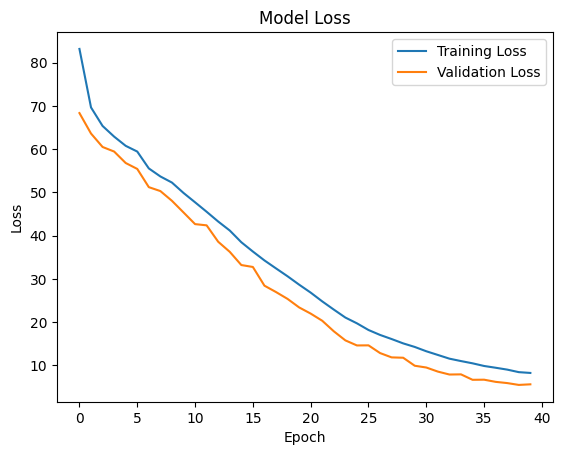

In [31]:
from matplotlib import pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [32]:
# Save the model in the native Keras format
from tensorflow.keras.models import save_model
save_model(model, 'models/my_model.keras')


الحمد الله